# Bidirectional GRU

Same as GRU 20 but more epochs. 


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit

# from sklearn.preprocessing import OneHotEncoder

# For the manual cross validation
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.set_floatx('float32')

EPOCHS=200
SPLITS=1
K=4
EMBED_DIMEN=16

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def build_model(maxlen,dimen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    rnn = keras.models.Sequential()
    embed_layer = keras.layers.Embedding(
        vocabulary_size,EMBED_DIMEN,input_length=maxlen);
    rnn1_layer = keras.layers.Bidirectional(
        keras.layers.GRU(32, return_sequences=True, dropout=0.50, 
            input_shape=[maxlen,dimen]))
    rnn2_layer = keras.layers.Bidirectional(
        keras.layers.GRU(32, dropout=0.50, return_sequences=True))
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = keras.layers.Dense(32,activation=act,dtype=dt)
    dense2_layer = keras.layers.Dense(32,activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [5]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    rnn2=None
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn2=build_model(maxlen,dimen)

        print("FIT")
        # this is complaining about string to float
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return rnn2

In [6]:
def make_kmers(MINLEN,MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
print("Load data from files.")
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


## Len 200-1Kb


Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[ 46 182 214 ...   0   0   0]
 [ 36 142  56 ...   0   0   0]
 [135  28 110 ...   0   0   0]
 ...
 [147  73  36 ...   0   0   0]
 [228 143  57 ...   0   0   0]
 [131  12  47 ...   0   0   0]]
Compile the model
COMPILE
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 16)          4112      
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 64)          9600      
______________________________________________

222/222 [==============================] - 291s 1s/step - loss: 0.3310 - accuracy: 0.8544 - val_loss: 0.3811 - val_accuracy: 0.8369
Epoch 46/200
222/222 [==============================] - 287s 1s/step - loss: 0.3341 - accuracy: 0.8532 - val_loss: 0.3948 - val_accuracy: 0.8214
Epoch 47/200
222/222 [==============================] - 286s 1s/step - loss: 0.3237 - accuracy: 0.8567 - val_loss: 0.3861 - val_accuracy: 0.8278
Epoch 48/200
222/222 [==============================] - 275s 1s/step - loss: 0.3298 - accuracy: 0.8557 - val_loss: 0.3794 - val_accuracy: 0.8297
Epoch 49/200
222/222 [==============================] - 275s 1s/step - loss: 0.3211 - accuracy: 0.8628 - val_loss: 0.4173 - val_accuracy: 0.8134
Epoch 50/200
222/222 [==============================] - 274s 1s/step - loss: 0.3247 - accuracy: 0.8592 - val_loss: 0.4098 - val_accuracy: 0.8217
Epoch 51/200
222/222 [==============================] - 276s 1s/step - loss: 0.3198 - accuracy: 0.8644 - val_loss: 0.4177 - val_accuracy: 0.816

222/222 [==============================] - 276s 1s/step - loss: 0.2672 - accuracy: 0.8879 - val_loss: 0.4243 - val_accuracy: 0.8103
Epoch 102/200
222/222 [==============================] - 278s 1s/step - loss: 0.2648 - accuracy: 0.8872 - val_loss: 0.4432 - val_accuracy: 0.8169
Epoch 103/200
222/222 [==============================] - 276s 1s/step - loss: 0.2633 - accuracy: 0.8885 - val_loss: 0.4236 - val_accuracy: 0.8128
Epoch 104/200
222/222 [==============================] - 278s 1s/step - loss: 0.2631 - accuracy: 0.8913 - val_loss: 0.4308 - val_accuracy: 0.8259
Epoch 105/200
222/222 [==============================] - 275s 1s/step - loss: 0.2680 - accuracy: 0.8858 - val_loss: 0.4228 - val_accuracy: 0.8187
Epoch 106/200
222/222 [==============================] - 275s 1s/step - loss: 0.2591 - accuracy: 0.8922 - val_loss: 0.4265 - val_accuracy: 0.8173
Epoch 107/200
222/222 [==============================] - 276s 1s/step - loss: 0.2549 - accuracy: 0.8942 - val_loss: 0.4324 - val_accuracy:

222/222 [==============================] - 327s 1s/step - loss: 0.2092 - accuracy: 0.9137 - val_loss: 0.4878 - val_accuracy: 0.8108
Epoch 158/200
222/222 [==============================] - 327s 1s/step - loss: 0.2079 - accuracy: 0.9159 - val_loss: 0.4960 - val_accuracy: 0.8254
Epoch 159/200
222/222 [==============================] - 322s 1s/step - loss: 0.2025 - accuracy: 0.9191 - val_loss: 0.4755 - val_accuracy: 0.8171
Epoch 160/200
222/222 [==============================] - 319s 1s/step - loss: 0.2046 - accuracy: 0.9172 - val_loss: 0.5192 - val_accuracy: 0.8124
Epoch 161/200
222/222 [==============================] - 22600s 102s/step - loss: 0.2114 - accuracy: 0.9128 - val_loss: 0.4658 - val_accuracy: 0.8236
Epoch 162/200
222/222 [==============================] - 287s 1s/step - loss: 0.2061 - accuracy: 0.9188 - val_loss: 0.4880 - val_accuracy: 0.8193
Epoch 163/200
222/222 [==============================] - 286s 1s/step - loss: 0.2051 - accuracy: 0.9175 - val_loss: 0.4788 - val_accur

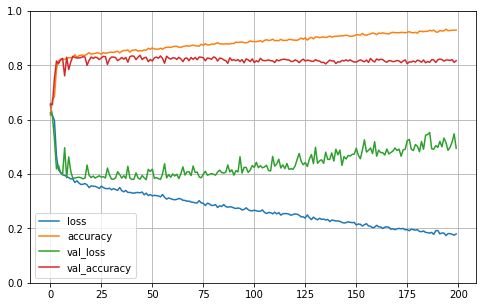

accuracy: 81.71%

Validation core mean 81.71% (+/- 0.00%)


In [8]:
MINLEN=200
MAXLEN=1000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model1=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

## Len 1K-2Kb

Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(3368, 1)
sequence    GGCGGGGTCGACTGACGGTAACGGGGCAGAGAGGCTGTTCGCAGAG...
Name: 12641, dtype: object
1338
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[167 155 107 ...   0   0   0]
 [226 133  20 ...   0   0   0]
 [108 175 186 ...   0   0   0]
 ...
 [175 185 225 ...   0   0   0]
 [ 37 148  78 ...   0   0   0]
 [188 240 192 ...   0   0   0]]
Compile the model
COMPILE
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 16)          4112      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2000, 64)          9600      
__________________________________________

Epoch 46/200
85/85 [==============================] - 237s 3s/step - loss: 0.3312 - accuracy: 0.8629 - val_loss: 0.3333 - val_accuracy: 0.8571
Epoch 47/200
85/85 [==============================] - 235s 3s/step - loss: 0.3022 - accuracy: 0.8755 - val_loss: 0.3420 - val_accuracy: 0.8587
Epoch 48/200
85/85 [==============================] - 235s 3s/step - loss: 0.3045 - accuracy: 0.8759 - val_loss: 0.3506 - val_accuracy: 0.8521
Epoch 49/200
85/85 [==============================] - 237s 3s/step - loss: 0.3138 - accuracy: 0.8686 - val_loss: 0.3381 - val_accuracy: 0.8450
Epoch 50/200
85/85 [==============================] - 238s 3s/step - loss: 0.3005 - accuracy: 0.8776 - val_loss: 0.3750 - val_accuracy: 0.8286
Epoch 51/200
85/85 [==============================] - 237s 3s/step - loss: 0.2968 - accuracy: 0.8815 - val_loss: 0.3542 - val_accuracy: 0.8366
Epoch 52/200
85/85 [==============================] - 238s 3s/step - loss: 0.2944 - accuracy: 0.8831 - val_loss: 0.3397 - val_accuracy: 0.8533

85/85 [==============================] - 228s 3s/step - loss: 0.2688 - accuracy: 0.8931 - val_loss: 0.3582 - val_accuracy: 0.8388
Epoch 104/200
85/85 [==============================] - 228s 3s/step - loss: 0.2806 - accuracy: 0.8848 - val_loss: 0.3486 - val_accuracy: 0.8415
Epoch 105/200
85/85 [==============================] - 228s 3s/step - loss: 0.2709 - accuracy: 0.8944 - val_loss: 0.3586 - val_accuracy: 0.8417
Epoch 106/200
85/85 [==============================] - 228s 3s/step - loss: 0.2604 - accuracy: 0.8985 - val_loss: 0.4514 - val_accuracy: 0.8061
Epoch 107/200
85/85 [==============================] - 236s 3s/step - loss: 0.2625 - accuracy: 0.8976 - val_loss: 0.3561 - val_accuracy: 0.8528
Epoch 108/200
85/85 [==============================] - 234s 3s/step - loss: 0.2616 - accuracy: 0.8982 - val_loss: 0.3440 - val_accuracy: 0.8512
Epoch 109/200
85/85 [==============================] - 234s 3s/step - loss: 0.2655 - accuracy: 0.8903 - val_loss: 0.3468 - val_accuracy: 0.8502
Epoch 

Epoch 160/200
85/85 [==============================] - 239s 3s/step - loss: 0.2058 - accuracy: 0.9257 - val_loss: 0.3731 - val_accuracy: 0.8453
Epoch 161/200
85/85 [==============================] - 239s 3s/step - loss: 0.2203 - accuracy: 0.9136 - val_loss: 0.3618 - val_accuracy: 0.8435
Epoch 162/200
85/85 [==============================] - 239s 3s/step - loss: 0.2024 - accuracy: 0.9242 - val_loss: 0.3882 - val_accuracy: 0.8330
Epoch 163/200
85/85 [==============================] - 239s 3s/step - loss: 0.2067 - accuracy: 0.9235 - val_loss: 0.4619 - val_accuracy: 0.8228
Epoch 164/200
85/85 [==============================] - 237s 3s/step - loss: 0.1992 - accuracy: 0.9285 - val_loss: 0.4101 - val_accuracy: 0.8291
Epoch 165/200
85/85 [==============================] - 238s 3s/step - loss: 0.2152 - accuracy: 0.9204 - val_loss: 0.3874 - val_accuracy: 0.8327
Epoch 166/200
85/85 [==============================] - 238s 3s/step - loss: 0.2070 - accuracy: 0.9205 - val_loss: 0.4402 - val_accuracy:

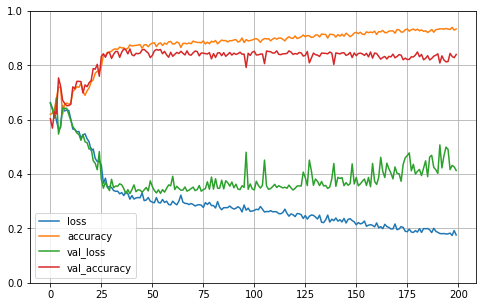

accuracy: 84.00%

Validation core mean 84.00% (+/- 0.00%)


In [9]:
MINLEN=1000
MAXLEN=2000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model2=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

## Len 2K-3Kb

Working on full training set, slice by sequence length.
Slice size range [2000 - 3000)
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
Sequence to Kmer
<class 'pandas.core.frame.DataFrame'>
(1351, 1)
sequence    GTCATTCTAGCTGCCTGCTGCCTCCGCAGCGTCCCCCCAGCTCTCC...
Name: 19713, dtype: object
2039
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[[181 212  80 ...   0   0   0]
 [ 10  37 148 ...   0   0   0]
 [ 48 190 245 ...   0   0   0]
 ...
 [ 49 195  10 ...   0   0   0]
 [153  97 131 ...   0   0   0]
 [ 36 143  58 ...   0   0   0]]
Compile the model
COMPILE
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 3000, 16)          4112      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 3000, 64)          9600      
__________________________________________

Epoch 46/200
34/34 [==============================] - 172s 5s/step - loss: 0.2214 - accuracy: 0.9145 - val_loss: 0.3662 - val_accuracy: 0.8336
Epoch 47/200
34/34 [==============================] - 166s 5s/step - loss: 0.2119 - accuracy: 0.9172 - val_loss: 0.3231 - val_accuracy: 0.8489
Epoch 48/200
34/34 [==============================] - 164s 5s/step - loss: 0.1988 - accuracy: 0.9277 - val_loss: 0.2535 - val_accuracy: 0.8892
Epoch 49/200
34/34 [==============================] - 166s 5s/step - loss: 0.2086 - accuracy: 0.9169 - val_loss: 0.2878 - val_accuracy: 0.8772
Epoch 50/200
34/34 [==============================] - 166s 5s/step - loss: 0.1866 - accuracy: 0.9243 - val_loss: 0.3219 - val_accuracy: 0.8553
Epoch 51/200
34/34 [==============================] - 164s 5s/step - loss: 0.1993 - accuracy: 0.9193 - val_loss: 0.2719 - val_accuracy: 0.8826
Epoch 52/200
34/34 [==============================] - 165s 5s/step - loss: 0.1976 - accuracy: 0.9236 - val_loss: 0.2520 - val_accuracy: 0.8896

34/34 [==============================] - 170s 5s/step - loss: 0.1237 - accuracy: 0.9576 - val_loss: 0.2792 - val_accuracy: 0.8916
Epoch 104/200
34/34 [==============================] - 170s 5s/step - loss: 0.1322 - accuracy: 0.9554 - val_loss: 0.2668 - val_accuracy: 0.8895
Epoch 105/200
34/34 [==============================] - 170s 5s/step - loss: 0.1151 - accuracy: 0.9666 - val_loss: 0.2941 - val_accuracy: 0.8838
Epoch 106/200
34/34 [==============================] - 168s 5s/step - loss: 0.1059 - accuracy: 0.9675 - val_loss: 0.3065 - val_accuracy: 0.8908
Epoch 107/200
34/34 [==============================] - 164s 5s/step - loss: 0.1342 - accuracy: 0.9523 - val_loss: 0.3019 - val_accuracy: 0.8878
Epoch 108/200
34/34 [==============================] - 164s 5s/step - loss: 0.1241 - accuracy: 0.9604 - val_loss: 0.2714 - val_accuracy: 0.8976
Epoch 109/200
34/34 [==============================] - 165s 5s/step - loss: 0.1002 - accuracy: 0.9725 - val_loss: 0.3191 - val_accuracy: 0.8725
Epoch 

Epoch 160/200
34/34 [==============================] - 170s 5s/step - loss: 0.1145 - accuracy: 0.9585 - val_loss: 0.3102 - val_accuracy: 0.8882
Epoch 161/200
34/34 [==============================] - 170s 5s/step - loss: 0.1094 - accuracy: 0.9623 - val_loss: 0.3849 - val_accuracy: 0.8827
Epoch 162/200
34/34 [==============================] - 170s 5s/step - loss: 0.1205 - accuracy: 0.9614 - val_loss: 0.2953 - val_accuracy: 0.8874
Epoch 163/200
34/34 [==============================] - 170s 5s/step - loss: 0.0719 - accuracy: 0.9798 - val_loss: 0.3016 - val_accuracy: 0.8940
Epoch 164/200
34/34 [==============================] - 173s 5s/step - loss: 0.0715 - accuracy: 0.9778 - val_loss: 0.3104 - val_accuracy: 0.9032
Epoch 165/200
34/34 [==============================] - 171s 5s/step - loss: 0.0895 - accuracy: 0.9702 - val_loss: 0.3093 - val_accuracy: 0.8981
Epoch 166/200
34/34 [==============================] - 165s 5s/step - loss: 0.0935 - accuracy: 0.9674 - val_loss: 0.3234 - val_accuracy:

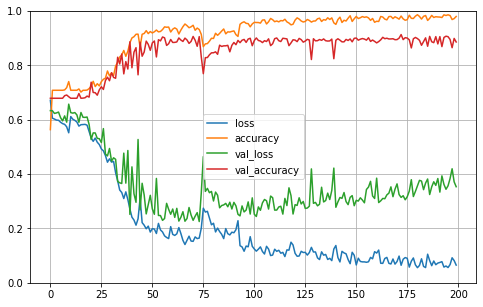

accuracy: 88.60%

Validation core mean 88.60% (+/- 0.00%)


In [10]:
MINLEN=2000
MAXLEN=3000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model3=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)

In [11]:
model1.save('EMB32.Short.model')
model2.save('EMB32.Medium.model')
model3.save('EMB32.Long.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: EMB32.Short.model/assets
INFO:tensorflow:Assets written to: EMB32.Medium.model/assets
INFO:tensorflow:Assets written to: EMB32.Long.model/assets
